<a href="https://colab.research.google.com/github/Alan240124/Alan/blob/main/Matricas(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert("L")  # Converter para grayscale
        mask = Image.open(mask_path).convert("L")    # Converter para grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Diretórios das imagens e máscaras
image_dir = '/content/drive/MyDrive/DataSet3/images'  # Substitua pelo caminho real
mask_dir = '/content/drive/MyDrive/DataSet3/masks'    # Substitua pelo caminho real

# Transformação (exemplo: converter para tensor)
#transform = transforms.ToTensor()
# Transforma as imagens para tensor e normaliza
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensione conforme necessário
    transforms.ToTensor(),
])

# Criação do dataset e do DataLoader
dataset = HeartDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exibir algumas informações do dataset
print(f"Total de imagens no dataset: {len(dataset)}")

# Exemplo de iteração pelo DataLoader
for images, masks in dataloader:
    print(f"Tamanho do batch de imagens: {images.shape}")
    print(f"Tamanho do batch de máscaras: {masks.shape}")
    break  # Apenas um batch para demonstração

Total de imagens no dataset: 9
Tamanho do batch de imagens: torch.Size([4, 1, 256, 256])
Tamanho do batch de máscaras: torch.Size([4, 1, 256, 256])


In [ ]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.conv_last(d1))

# Inicializar o modelo e definir o otimizador e a função de perda
model = UNet()
criterion = nn.BCELoss()  # Usamos BCELoss para segmentação binária
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}")

    # Salva o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

Epoch [1/10], Loss: 0.6958550214767456
Epoch [2/10], Loss: 1.455963174502055
Epoch [3/10], Loss: 0.6368423700332642
Epoch [4/10], Loss: 0.6564529538154602
Epoch [5/10], Loss: 0.6488561034202576
Epoch [6/10], Loss: 0.6195462346076965
Epoch [7/10], Loss: 0.567632814248403
Epoch [8/10], Loss: 1.0329732199509938
Epoch [9/10], Loss: 0.43941692511240643
Epoch [10/10], Loss: 0.4139211376508077


In [ ]:
import torch

# Configuração do dispositivo (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        # Movendo dados para o dispositivo
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumulando a perda para monitoramento
        epoch_loss += loss.item()

    # Exibindo a perda média por epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}")

    # Salvando o modelo após cada epoch
    torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

# Função para calcular o coeficiente DICE
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Avaliação com uma batch do DataLoader
model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Predições do modelo
        outputs = model(images)

        # Cálculo do coeficiente DICE
        dice = dice_coefficient(outputs, masks)
        print("DICE coefficient:", dice.item())
        break  # Apenas para a primeira batch


Epoch [1/10], Loss: 0.35077422857284546
Epoch [2/10], Loss: 0.27069635192553204
Epoch [3/10], Loss: 0.17564714948336282
Epoch [4/10], Loss: 0.13759919504324594
Epoch [5/10], Loss: 0.11782571176687877
Epoch [6/10], Loss: 0.09558909634749095
Epoch [7/10], Loss: 0.11719811459382375
Epoch [8/10], Loss: 0.0980186474819978
Epoch [9/10], Loss: 0.11797871937354405
Epoch [10/10], Loss: 0.09303215270241101
DICE coefficient: 0.8855553269386292


In [ ]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Exemplo de uso com uma batch do DataLoader
model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        dice = dice_coefficient(outputs, masks)
        print("DICE coefficient:", dice.item())
        break  # Apenas para uma batch

DICE coefficient: 0.8646488785743713


In [ ]:
import torch
import numpy as np

# Função de cálculo do DICE coefficient
def dice_coefficient(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()  # Binarizar a predição
    target = (target > 0.5).float()  # Binarizar a máscara
    intersection = (pred * target).sum()  # Calcular a interseção
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)  # Fórmula do DICE

# Função de cálculo da Intersection over Union (IoU)
def iou_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()  # Interseção
    union = pred.sum() + target.sum() - intersection  # União
    return (intersection + epsilon) / (union + epsilon)  # Fórmula do IoU

# Função de cálculo da Accuracy
def accuracy_score(pred, target):
    pred = (pred > 0.5).float()  # Binarizar a predição
    target = (target > 0.5).float()  # Binarizar a máscara
    correct = (pred == target).sum()  # Contar acertos
    total = target.numel()  # Total de pixels
    return correct / total  # Proporção de acertos

# Exemplo de uso com uma batch do DataLoader
model.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desliga o cálculo de gradientes
    for images, masks in dataloader:  # Loop sobre as batches
        images = images.to(device)  # Mover para o dispositivo (GPU ou CPU)
        masks = masks.to(device)

        # Passando as imagens pela rede
        outputs = model(images)

        # Calcular as métricas
        dice = dice_coefficient(outputs, masks)  # DICE coefficient
        iou = iou_score(outputs, masks)  # IoU
        accuracy = accuracy_score(outputs, masks)  # Accuracy

        # Exibindo os resultados
        print(f"DICE coefficient: {dice.item():.4f}")
        print(f"IoU score: {iou.item():.4f}")
        print(f"Accuracy: {accuracy.item():.4f}")

        break  # Apenas para uma batch, remova esta linha para calcular para todas as batches


DICE coefficient: 0.9055
IoU score: 0.8273
Accuracy: 0.9582


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU

# Função para carregar o dataset
def load_data(images_path, masks_path, img_size=(128, 128)):
    images = []
    masks = []

    for img_name in sorted(os.listdir(images_path)):
        img = tf.keras.preprocessing.image.load_img(os.path.join(images_path, img_name), target_size=img_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img)

    for mask_name in sorted(os.listdir(masks_path)):
        mask = tf.keras.preprocessing.image.load_img(os.path.join(masks_path, mask_name), color_mode='grayscale', target_size=img_size)
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
        masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    return train_test_split(images, masks, test_size=0.2, random_state=42)

# Função para definir o modelo CNN
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    return model

# Criar a métrica MeanIoU fora da função iou_metric
metric = MeanIoU(num_classes=2)

# Função de métrica personalizada (usando MeanIoU)
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    metric.update_state(y_true, y_pred)
    return metric.result()

# Função para monitorar o treinamento
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return [early_stopping]

# Função principal de treinamento
def main(images_path, masks_path):
    # Carregar dados
    X_train, X_val, y_train, y_val = load_data(images_path, masks_path)

    # Definir modelo
    input_shape = X_train.shape[1:]
    model = create_cnn_model(input_shape)

    # Compilar modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_metric])

    # Treinar modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=8,
                        callbacks=get_callbacks())

    # Avaliar o modelo
    val_loss, val_iou = model.evaluate(X_val, y_val)
    print(f"Validation IoU: {val_iou:.4f}")

    return model, history

# Caminhos para as pastas de imagens e máscaras
images_path = '/content/drive/MyDrive/DataSet3/images'
masks_path = '/content/drive/MyDrive/DataSet3/masks'

# Executar o treinamento
if __name__ == "__main__":
    model, history = main(images_path, masks_path)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - iou_metric: 0.3170 - loss: 0.6931 - val_iou_metric: 0.3462 - val_loss: 0.6916
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step - iou_metric: 0.3803 - loss: 0.6917 - val_iou_metric: 0.3905 - val_loss: 0.6895
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - iou_metric: 0.4056 - loss: 0.6898 - val_iou_metric: 0.4102 - val_loss: 0.6861
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - iou_metric: 0.4167 - loss: 0.6865 - val_iou_metric: 0.4195 - val_loss: 0.6806
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - iou_metric: 0.4234 - loss: 0.6813 - val_iou_metric: 0.4252 - val_loss: 0.6717
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - iou_metric: 0.4271 - loss: 0.6729 - val_iou_metric: 0.4284 - val_loss: 0.6584
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - iou_metric: 0.4295 - loss: 0.6606 - val_iou_metric: 0.4306 - val_loss: 0.6403
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - iou_metric: 0.4312 - loss: 0.6450 - val_iou_metric: 0.4

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5886 - loss: 0.6922
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6865 - loss: 0.6867
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6911 - loss: 0.6758
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6532 - loss: 0.6611
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - accuracy: 0.6532 - loss: 0.6398
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step - accuracy: 0.6803 - loss: 0.6313
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - accuracy: 0.6803 - loss: 0.6295
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.6803 - loss: 0.6142
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.6532 - loss: 0.6155
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.6845 - loss: 0.6009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


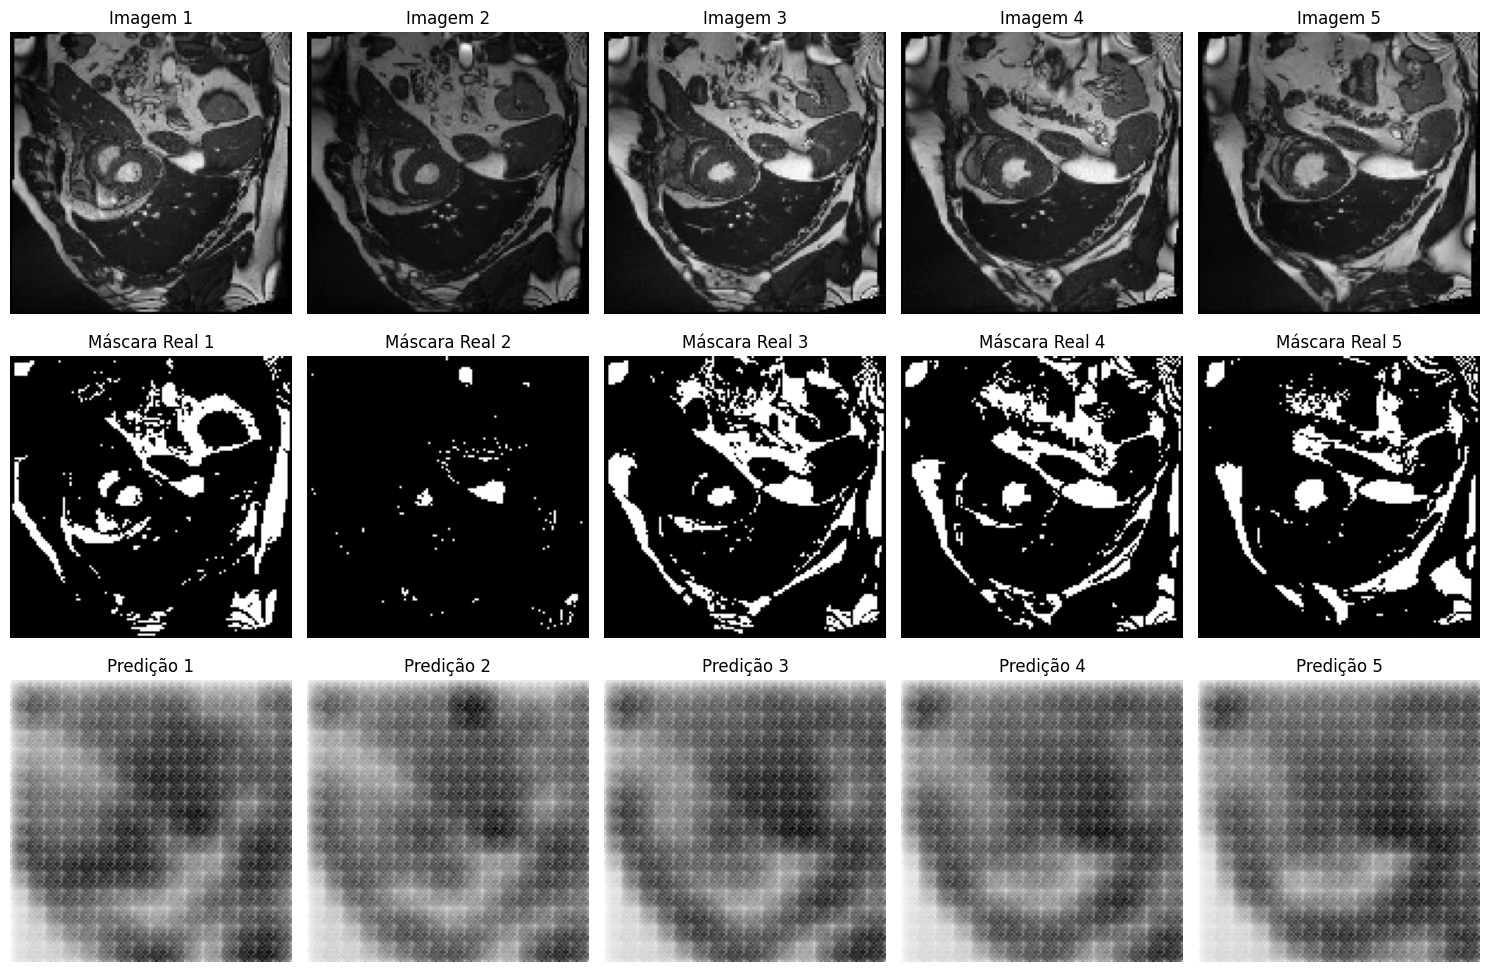

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Função para carregar e pré-processar as imagens e máscaras
def data(images_path, masks_path, img_size=(128, 128)):
    """
    Carrega e pré-processa as imagens e máscaras para segmentação.

    Parameters:
    - images_path: Caminho das imagens.
    - masks_path: Caminho das máscaras.
    - img_size: Tamanho de redimensionamento das imagens.

    Returns:
    - images: Numpy array com as imagens carregadas e normalizadas.
    - masks: Numpy array com as máscaras carregadas e normalizadas.
    """

    images = []
    masks = []

    for img_name in sorted(os.listdir(images_path)):
        # Carregar a imagem
        img = load_img(os.path.join(images_path, img_name), target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalizar a imagem
        images.append(img)

    for mask_name in sorted(os.listdir(masks_path)):
        # Carregar a máscara
        mask = load_img(os.path.join(masks_path, mask_name), color_mode='grayscale', target_size=img_size)
        mask = img_to_array(mask) / 255.0  # Normalizar a máscara
        masks.append(mask)

    # Converter para numpy arrays
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    # Adicionar a dimensão extra para a máscara (se necessário)
    if len(masks.shape) == 3:
        masks = np.expand_dims(masks, axis=-1)

    return images, masks

# DataLoader para carregar o dataset em lotes
class SegmentationDataLoader(Sequence):
    def __init__(self, images_path, masks_path, batch_size=8, img_size=(128, 128), shuffle=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.images, self.masks = data(images_path, masks_path, img_size)
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()  # Embaralhar os dados inicialmente

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_masks = self.masks[batch_indices]
        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Função para definir o modelo CNN de segmentação
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),

        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    return model

# Função para treinar o modelo
def train_and_evaluate_model(images_path, masks_path, img_size=(128, 128), batch_size=8, epochs=50):
    # Criar o DataLoader
    train_loader = SegmentationDataLoader(images_path, masks_path, batch_size=batch_size, img_size=img_size)

    # Definir o modelo
    input_shape = (img_size[0], img_size[1], 3)  # 3 canais para RGB
    model = create_cnn_model(input_shape)

    # Compilar o modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treinamento
    history = model.fit(train_loader, epochs=epochs)

    return model, history

# Função para visualizar as previsões
def visualize_predictions(model, images_path, masks_path, img_size=(128, 128)):
    # Carregar as primeiras 5 imagens e máscaras
    images, masks = data(images_path, masks_path, img_size)

    # Prever as máscaras para as primeiras 5 imagens
    preds = model.predict(images[:5])

    plt.figure(figsize=(15, 10))

    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Imagem {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+6)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Máscara Real {i+1}")
        plt.axis('off')

        plt.subplot(3, 5, i+11)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title(f"Predição {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Função principal para treinar, avaliar e visualizar o modelo
def main():
    # Caminhos para as pastas de imagens e máscaras
    images_path = '/content/drive/MyDrive/DataSet3/images'  # Substitua pelo caminho da sua pasta de imagens
    masks_path = '/content/drive/MyDrive/DataSet3/masks'    # Substitua pelo caminho da sua pasta de máscaras

    # Treinamento e avaliação
    model, history = train_and_evaluate_model(images_path, masks_path, img_size=(128, 128), batch_size=8, epochs=10)

    # Visualizar as previsões
    visualize_predictions(model, images_path, masks_path, img_size=(128, 128))

if __name__ == "__main__":
    main()
